# Homework 3

### Shadrunov Aleksey
### BIB201
### Dec 13, 2022

# Task 1. EM

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

## Explore data

In [20]:
wine = load_wine()
print(wine.DESCR[550:1585])

X = wine.data
y = wine.target


    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Magnesium:                    70.0 162.0    99.7  14.3
    Total Phenols:                0.98  3.88    2.29  0.63
    Flavanoids:                   0.34  5.08    2.03  1.00
    Nonflavanoid Phenols:         0.13  0.66    0.36  0.12
    Proanthocyanins:              0.41  3.58    1.59  0.57
    Colour Intensity:              1.3  13.0     5.1   2.3
    Hue:                          0.48  1.71    0.96  0.23
    OD280/OD315 of diluted wines: 1.27  4.00    2.61  0.71
    Proline:                       278  1680     746   315
    =====================

попробуем понять, какие статистики влияют на распределение по классам. 

In [21]:
print("{:<10}{:>10}".format("Statistic", "Correlation"))

for i in range(13):
    print("{:<10}{:>10.3f}".format(i, np.corrcoef(X[:,i], y)[0][1]))

Statistic Correlation
0             -0.328
1              0.438
2             -0.050
3              0.518
4             -0.209
5             -0.719
6             -0.847
7              0.489
8             -0.499
9              0.266
10            -0.617
11            -0.788
12            -0.634


выберем статистики **5, 6, 11**, так как они по модулю имеют наибольшее значение коэффициента.

In [22]:
X = wine.data[:, [5, 6, 11]]
X[:7], y[:7]

(array([[2.8 , 3.06, 3.92],
        [2.65, 2.76, 3.4 ],
        [2.8 , 3.24, 3.17],
        [3.85, 3.49, 3.45],
        [2.8 , 2.69, 2.93],
        [3.27, 3.39, 2.85],
        [2.5 , 2.52, 3.58]]),
 array([0, 0, 0, 0, 0, 0, 0]))

## Theory

для решения задачи понадобится имплементация функция плотности вероятности n-мерного нормального распределения (https://ru.wikipedia.org/wiki/Многомерное_нормальное_распределение):

![](2.png)

а также математическое описание ЕМ-алгоритма. адекватное описание найдено на странице: https://python-course.eu/machine-learning/expectation-maximization-and-gaussian-mixture-models-gmm.php

![](1.png)


ещё раз кратко обозначим задачу: нужно разделить

### смесь многомерных распределений
то есть сумму многомерных распределений с весами

определим наши переменные:  

в случае трех компонент функция плотности вероятности:  
$$N(x) = w_1 N_1(x) + w_2 N_2(x) + w_3 N_3(x)$$

### функция плотности распределения:
$$N(x) = w_1 N(x, M_1, \Sigma_1) + w_2 N(x, M_2, \Sigma_2) + w_3 N(x, M_3, \Sigma_3)$$

$k$ — число кластеров ($c$ на картинке выше)   
$q$ — размерность, число координат   
$n$ — число объектов   

### Вектор **весов**:
$$
W = [w_1, w_2, w_3]
$$

### Вектор **средних** для смеси распределений:
$$
M_{mix} = \begin{bmatrix} M_1, M_2, M_3 \end{bmatrix} = 
\begin{bmatrix}
[\mu_{11} & \mu_{12} & \mu_{13}], [\mu_{21} & \mu_{22} & \mu_{23}], [\mu_{31} & \mu_{32} & \mu_{33}] \end{bmatrix}
$$
Размерность: $k \times q$ (число компонент в смеси $\times$ число измерений в каждом распределении в смеси)


### Вектор **матриц ковариации** для смеси распределений:
$$
C_{mix} = \begin{bmatrix} \Sigma_1, \Sigma_2, \Sigma_3 \end{bmatrix} = 
\begin{bmatrix}
\begin{pmatrix}
\dots & \dots & \dots \\
\dots & \dots & \dots \\
\dots & \dots & \dots 
\end{pmatrix}, \\
\begin{pmatrix}
\dots & \dots & \dots \\
\dots & \dots & \dots \\
\dots & \dots & \dots 
\end{pmatrix}, \\
\begin{pmatrix}
\dots & \dots & \dots \\
\dots & \dots & \dots \\
\dots & \dots & \dots 
\end{pmatrix}, \\

\end{bmatrix}
$$
Размерность: $k \times (q \times q)$ (число компонент в смеси $\times$ размерность матрицы ковариации для каждой компоненты)

### Алгоритм
#### E-step
* for i in dataset, j in clusters:
$$
G[i][j] = \frac{W_{mix}[j] * N(X[i], M_{mix}[j], S_{mix}[j])}{\sum_{j=1}^{k} W_{mix}[j] * N(X[i], M_{mix}[j], S_{mix}[j])}
$$
N is Gaussian (described above)

$G[i][j]$ is $\frac{Probability \ that \ X[i] \ belongs \ to \ class \ j}{Probability \ of \ X[i] \ over \ all \ classes}$ (Bayes)

#### M-step
* for each cluster j, for i in dataset, $n = len(X)$:
$$
W_{mix}[j] = \frac{ \sum_i G[i][j] }{n} \\

M_{mix}[j] = \frac{1}{W_{mix}[j]} \sum_i G[i][j] X[i] \\

S_{mix}[j] = \frac{1}{W_{mix}[j]} \sum_i G[i][j] (X[i] - M_{mix}[j])^T (X[i] - M_{mix}[j])
$$


In [23]:
# переменные

# вектор весов: вероятность принадлежности i классу
# W_mix = [w1, w2, w3]

# вектор средних: среднее для каждого класса тоже вектор
# M_mix = [M1, M2, M3] = [[mu1, mu2, mu3], [mu1, mu2, mu3], [mu1, mu2, mu3]]

# матрица ковариаций для трех нормальных распределений
# S_mix = [S1, S2, S3] = [[...], [...], [...]]

# k - number of clusters
# n - number of objects
# q - number of dimensions (features)

## Implementaion

In [43]:
def N(x, mean, cov) -> float:
    """Multidimensional Gaussian

    :param x: vector of n floats
    :type x: list
    :param mean: vector of n floats
    :type mean: list
    :param cov: square matrix of the covariances between each pair of elements
    :type cov: np.matrix
    :return: value of pdf for point x
    :rtype: float
    """
    n = len(mean)
    denom = np.sqrt(np.power(2 * np.pi, n) * np.linalg.det(cov))
    sub = np.matrix([x - mean])
    num = np.exp((-1.0 / 2) * sub * np.linalg.inv(cov) * sub.T)
    return float(num / denom)


def E_step(X, W_mix, M_mix, S_mix):
    """E_step calculates Bayes probability of X[i] residing in j cluster

    :param X: n*q matrix of input data 
    :type X: np.array
    :param W_mix: Vector (1*k) of weights in the mixture of distributions
    :type W_mix: np.array
    :param M_mix: Vector of vectors (k*q) of means of distributions
    :type M_mix: np.array
    :param S_mix: Vector of Covariance matrices (k*q*q) of each distribution 
    :type S_mix: np.array
    :return: calculated Bayes probabilities
    :rtype: np.array
    """

    n = len(X)  # number of objects
    k = len(W_mix)  # number of clusters
    G = np.zeros((n, k))

    for i in range(n):  # for each object in X
        denom = np.sum([W_mix[j] * N(X[i], M_mix[j], S_mix[j]) for j in range(k)])  # full probability
        for j in range(k):  # for each cluster
            num = W_mix[j] * N(X[i], M_mix[j], S_mix[j])
            G[i][j] = num / denom
    return G


def M_step(X, G):  # returns W_mix, M_mix, S_mix
    """Overestimation of vectors

    :param X: dataset, n*q
    :type X: np.array
    :param G: probabilities, n*k
    :type G: np.array
    :return: new W_mix, M_mix, S_mix
    :rtype: tuple
    """

    k = G.shape[1]  # number of clusters
    q = X.shape[1]  # number of dimensions
    n = X.shape[0]  # number of objects

    W_mix = np.sum(G, axis=0) / n  # recalc W

    M_mix = np.zeros((k, q))
    for j in range(k):
        M_mix[j] = np.sum([G[i][j] * X[i] for i in range(n)], axis=0) / np.sum(G, axis=0)[j]

    S_mix = np.zeros((k, q, q))
    for j in range(k):
        S_mix[j] = (
            np.sum([G[i][j] * np.matrix(X[i] - M_mix[j]).T * np.matrix(X[i] - M_mix[j]) for i in range(n)], axis=0)
            / np.sum(G, axis=0)[j]
        )
    S_mix = np.where(S_mix < 0, 0, S_mix)  # prevent negative values as in example

    return W_mix, M_mix, S_mix


def predict(G):
    """Guess class for each point in dataset

    :param G: probabilities of being a member of a class
    :type G: np.array
    :return: list with predicted labels
    :rtype: list
    """
    n = len(G)  # number of objects
    answers = []
    for i in range(n):
        res = np.argmax(G[i])  # the class with the highest probability
        answers.append(res)
    return np.array(answers)


Итерация № 5
Изменение дистанции между матрицами мат. ожиданий 	 0.0356666636998194
Доля правильно распознанных изделий 	 0.264
Матрица весов [0.33359773 0.33330632 0.33309595]


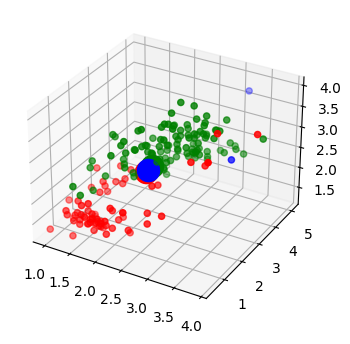

Итерация № 10
Изменение дистанции между матрицами мат. ожиданий 	 0.22509040714428574
Доля правильно распознанных изделий 	 0.309
Матрица весов [0.31809947 0.3871694  0.29473113]


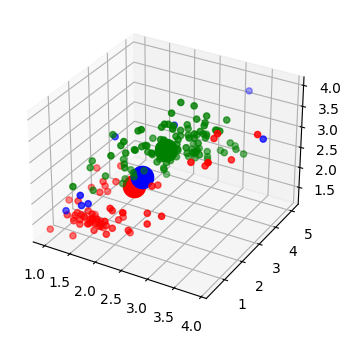

Итерация № 15
Изменение дистанции между матрицами мат. ожиданий 	 0.11850969107141371
Доля правильно распознанных изделий 	 0.253
Матрица весов [0.30146495 0.48238308 0.21615196]


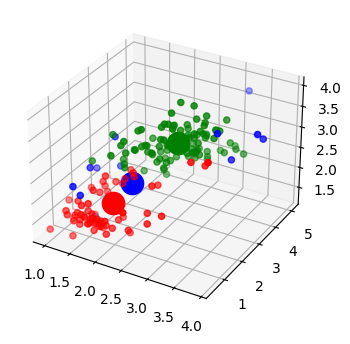

Итерация № 20
Изменение дистанции между матрицами мат. ожиданий 	 0.14848795940587337
Доля правильно распознанных изделий 	 0.253
Матрица весов [0.32136357 0.52282931 0.15580712]


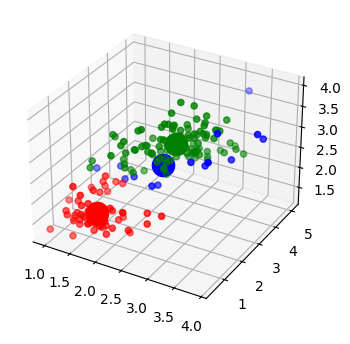

Итерация № 25
Изменение дистанции между матрицами мат. ожиданий 	 0.012943578896361297
Доля правильно распознанных изделий 	 0.287
Матрица весов [0.29747964 0.55119987 0.15132048]


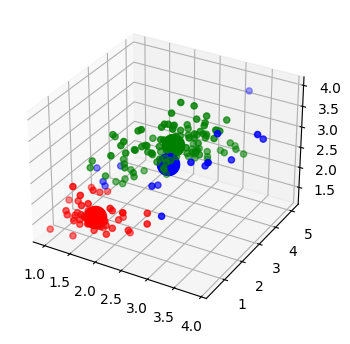

In [44]:
wine = load_wine()
X = wine.data[:, [5, 6, 11]]
y = wine.target

n = X.shape[0]  # number of objects
k = 3           # number of clusters
q = X.shape[1]  # number of dimensions (features)

W_mix = np.array([float(1.0 / k)] * k)  # initial weights are equal
np.random.seed(seed=None)
# initial means are just means, and Cov matrices just random and symmetrical and semipositive somewhat...
M_mix = np.array((np.mean(X[np.random.choice(n, int(n / k))], axis=0), np.mean(X[np.random.choice(n, int(n / k))], axis=0), np.mean(X[np.random.choice(n, int(n / k))], axis=0)))
S_mix = np.array(([[3, 1, 2], [1, 3, 1], [2, 1, 3]], [[3, 1, 2], [1, 3, 1], [2, 1, 3]], [[3, 1, 2], [1, 3, 1], [2, 1, 3]]))

# model constrains 
max_steps = 50
M_mix_0 = np.zeros((k, q))
iteration = 0

while (np.linalg.norm(M_mix - M_mix_0) > 0.01) and (iteration < max_steps):
    # distance between mean matrices is the metric of convergence
    M_mix_0 = M_mix
    iteration += 1
    
    G = E_step(X, W_mix, M_mix, S_mix)  # calc Bayes probabilities
    W_mix, M_mix, S_mix = M_step(X, G)  # evaluate vectors
    answers = predict(G)                # predict
    
    if not (iteration + 1) % 5:  # limit output to make it comprehensible
        print("Итерация №", iteration + 1)
        print("Изменение дистанции между матрицами мат. ожиданий \t", np.linalg.norm(M_mix - M_mix_0))
        print("Доля правильно распознанных изделий \t", round(accuracy_score(y, answers), 3))
        print("Матрица весов", W_mix)
        # print("Матрица значений математических ожиданий \t", M_mix)
        # print("Матрица значений стандартных отклонений \t", S_mix)

        fig = plt.figure(figsize=(4, 4))
        ax = plt.axes(projection="3d")
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=np.array(["r", "g", "b"])[answers])
        ax.plot(M_mix[0][0], M_mix[0][1], M_mix[0][2], 'o', markersize = 16, color = 'r')
        ax.plot(M_mix[1][0], M_mix[1][1], M_mix[1][2], 'o',  markersize = 16, color = 'g')
        ax.plot(M_mix[2][0], M_mix[2][1], M_mix[2][2], 'o',  markersize = 16, color = 'b')
        plt.show()

## Results

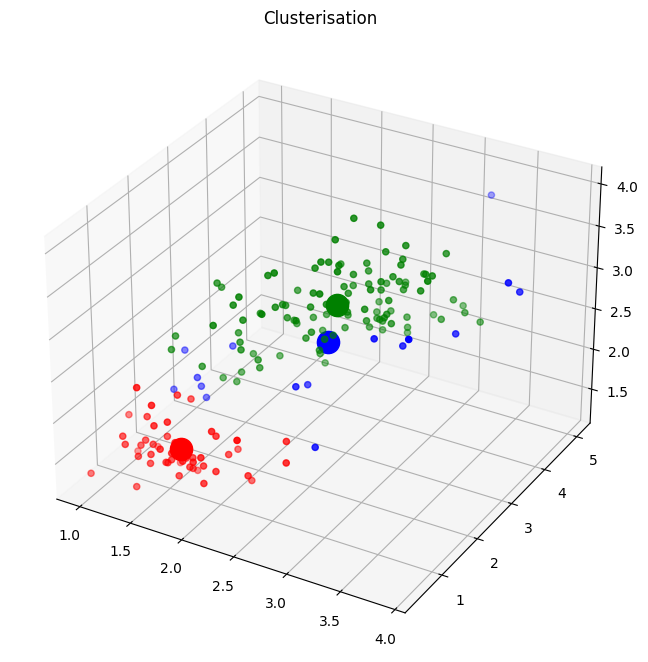

In [45]:
# plot final clusters

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection="3d")
colormap = np.array(["r", "g", "b"])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=colormap[answers])
ax.plot(M_mix[0][0], M_mix[0][1], M_mix[0][2], 'o', markersize = 16, color = 'r')
ax.plot(M_mix[1][0], M_mix[1][1], M_mix[1][2], 'o',  markersize = 16, color = 'g')
ax.plot(M_mix[2][0], M_mix[2][1], M_mix[2][2], 'o',  markersize = 16, color = 'b')
plt.title("Clusterisation")
plt.show()

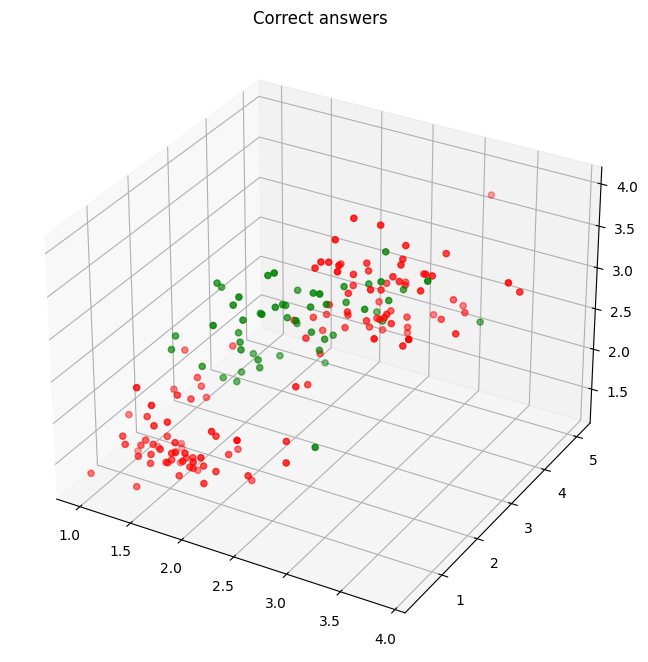

In [46]:
# plot correct answers

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection="3d")
colormap = np.array(["r", "g"])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=colormap[(answers == y) + 0])
plt.title("Correct answers")
plt.show()

## Metrics

we should calculate precision and recall as well, since these metrics are crucial in some situations. https://habr.com/ru/company/ods/blog/328372/

![](3.png)

In [47]:
print("{:<6}{:>12}{:>12}".format("Class", "Precision", "Recall"))

for j in range(k):
    print(
        "{:<6}{:>12.3f}{:>12.3f}".format(
            j, 
            sum(y[answers == j] == j) / len(y[answers == j]), 
            sum(y[answers == j] == j) / sum(y == j),
        )
    )
print("Accuracy: ", round(accuracy_score(y, answers), 3))


Class    Precision      Recall
0            0.000       0.000
1            0.472       0.718
2            0.062       0.021
Accuracy:  0.292


видно, что 0 класс мы вовсе не угадали.

## sklearn

let's compare our solution with **sklearn**

In [50]:
from sklearn.mixture import GaussianMixture as GMM

wine = load_wine()
X = wine.data
y = wine.target
X = X[:, [5, 6, 11]]

model = GMM(n_components=k, covariance_type="full")
model.fit(X)
answers = model.predict(X)

print("{:<6}{:>12}{:>12}".format("Class", "Precision", "Recall"))

for j in range(k):
    print(
        "{:<6}{:>12.3f}{:>12.3f}".format(
            j, 
            sum(y[answers == j] == j) / len(y[answers == j]), 
            sum(y[answers == j] == j) / sum(y == j),
        )
    )
print("Accuracy: ", round(accuracy_score(y, answers), 3))

Class    Precision      Recall
0            0.325       0.424
1            0.320       0.225
2            0.922       0.979
Accuracy:  0.494


так как алгоритм не детерминирован по входным параметрам, результат работы GaussianMixture всегда разный. в данном случае подобрал результат с accuracy 0.494 и precision/recall от 0.3 до 0.9, то есть в данном случае встроенный алгоритм отработал лучше. по наблюдениям, он часто работает лучше написанного нами))

# Task 2. kNN

проанализируем, как на алгоритм k-ближайших-соседей влияют его параметры, а также способы задания тренирующей и тестирующей выборок.

https://scikit-learn.ru/3-1-cross-validation-evaluating-estimator-performance/

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, LeaveOneOut, StratifiedKFold

In [31]:
wine = load_wine()
X = wine.data[:, [5, 6, 11]]
y = wine.target

results = {"kfold": [], "loo": [], "skf": []}

## без scale
### K-fold
метод делит выборку на **n_splits** групп, одна из них по очереди объявляется тестовой, а остальные данные образуют тренировочный датасет. процедура повторяется **n_splits** раз, таким образом, каждая группа успевает побыть тестовой.

K-fold


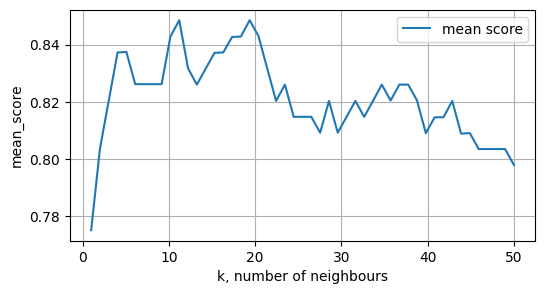

   Max score       K_max  Mean score
       0.849          10       0.821


In [32]:
# K-fold
print("K-fold")
kf = KFold(random_state=42, shuffle=True)
results["kfold"] = list()

for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = list()
    for _, (train_index, test_index) in enumerate(kf.split(X)):
        knn.fit(X[train_index], y[train_index])
        answers = knn.predict(X[test_index])
        score.append(accuracy_score(y[test_index], answers))
    results["kfold"].append(np.average(score))

plt.figure(figsize=(6, 3))
plt.grid()
plt.plot(np.linspace(1, 50, 49), results["kfold"], label="mean score")
plt.xlabel("k, number of neighbours")
plt.ylabel("mean_score")
plt.legend(loc="upper right")
plt.show()

print("{:>12}{:>12}{:>12}".format("Max score", "K_max", "Mean score"))
print("{:>12.3f}{:>12}{:>12.3f}".format(max(results["kfold"]), np.argmax(results["kfold"]), np.average(results["kfold"])))


### LeaveOneOut
k-fold с числом групп, равным числу объектов. метод включает все объекты, кроме одного, в тренировочную выборку. в тестовую попадает оставшийся объект. далее процедура повторяется для всех объектов.  

понятно, что такой подход подразумевает больше итераций, чем kfold, и в целом менее эффективен по времени.

LeaveOneOut


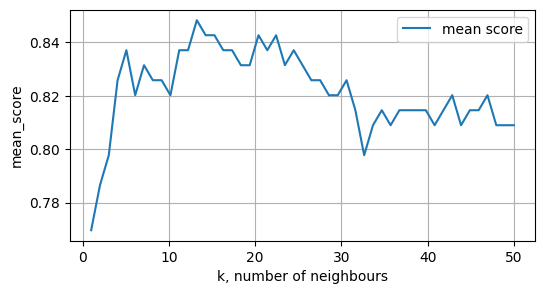

   Max score       K_max  Mean score
       0.848          12       0.822


In [33]:
# LeaveOneOut
print("LeaveOneOut")
loo = LeaveOneOut()
results["loo"] = list()

for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = list()
    for _, (train_index, test_index) in enumerate(loo.split(X)):
        knn.fit(X[train_index], y[train_index])
        answers = knn.predict(X[test_index])
        score.append(accuracy_score(y[test_index], answers))
    results["loo"].append(np.average(score))

plt.figure(figsize=(6, 3))
plt.grid()
plt.plot(np.linspace(1, 50, 49), results["loo"], label="mean score")
plt.xlabel("k, number of neighbours")
plt.ylabel("mean_score")
plt.legend(loc="upper right")
plt.show()

print("{:>12}{:>12}{:>12}".format("Max score", "K_max", "Mean score"))
print("{:>12.3f}{:>12}{:>12.3f}".format(max(results["loo"]), np.argmax(results["loo"]), np.average(results["loo"])))

### StratifiedKFold
k-fold, в котором в выборках содержатся примерно одинаковые пропорции целевых классов. для этого в качестве параметра передаем y. 

StratifiedKFold


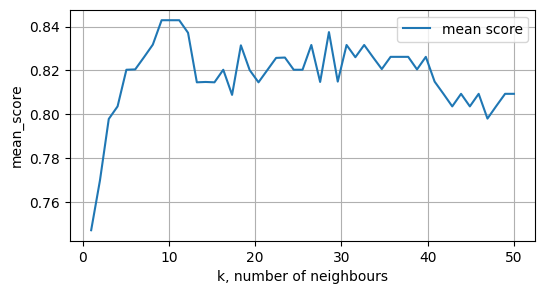

   Max score       K_max  Mean score
       0.843           8       0.818


In [34]:
# StratifiedKFold
print("StratifiedKFold")
skf = StratifiedKFold(random_state=42, shuffle=True)
results["skf"] = list()

for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = list()
    for _, (train_index, test_index) in enumerate(skf.split(X, y)):
        knn.fit(X[train_index], y[train_index])
        answers = knn.predict(X[test_index])
        score.append(accuracy_score(y[test_index], answers))
    results["skf"].append(np.average(score))

plt.figure(figsize=(6, 3))
plt.grid()
plt.plot(np.linspace(1, 50, 49), results["skf"], label="mean score")
plt.xlabel("k, number of neighbours")
plt.ylabel("mean_score")
plt.legend(loc="upper right")
plt.show()

print("{:>12}{:>12}{:>12}".format("Max score", "K_max", "Mean score"))
print("{:>12.3f}{:>12}{:>12.3f}".format(max(results["skf"]), np.argmax(results["skf"]), np.average(results["skf"])))

Подведем итоги. Наименьшее число соседей потребовалось алгоритму **StratifiedKFold**, наибольшее — **loo**. Правильность примерно одинакова.

In [35]:
print("{:>12}{:>12}{:>12}{:>12}".format("", "Max score", "K_max", "Mean score"))
for key in results:
    print("{:>12}{:>12.3f}{:>12}{:>12.3f}".format(key, max(results[key]), np.argmax(results[key]), np.average(results[key])))


               Max score       K_max  Mean score
       kfold       0.849          10       0.821
         loo       0.848          12       0.822
         skf       0.843           8       0.818


## scale
преобразуем датасет для лучшей обработки алгоритмом кластеризации

K-fold


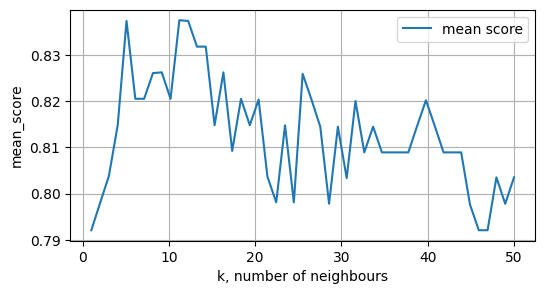

   Max score       K_max  Mean score
       0.837          10       0.813
LeaveOneOut


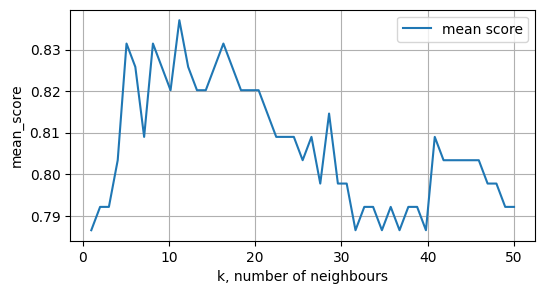

   Max score       K_max  Mean score
       0.837          10       0.807
StratifiedKFold


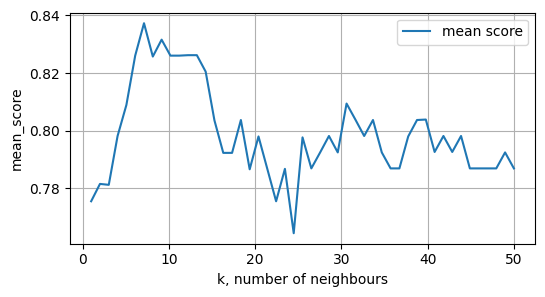

   Max score       K_max  Mean score
       0.837           6       0.799

               Max score       K_max  Mean score
       kfold       0.837          10       0.813
         loo       0.837          10       0.807
         skf       0.837           6       0.799


In [36]:
X = scale(X)

results = {"kfold": [], "loo": [], "skf": []}

# K-fold
print("K-fold")
kf = KFold(random_state=42, shuffle=True)
results["kfold"] = list()

for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = list()
    for _, (train_index, test_index) in enumerate(kf.split(X)):
        knn.fit(X[train_index], y[train_index])
        answers = knn.predict(X[test_index])
        score.append(accuracy_score(y[test_index], answers))
    results["kfold"].append(np.average(score))

plt.figure(figsize=(6, 3))
plt.grid()
plt.plot(np.linspace(1, 50, 49), results["kfold"], label="mean score")
plt.xlabel("k, number of neighbours")
plt.ylabel("mean_score")
plt.legend(loc="upper right")
plt.show()

print("{:>12}{:>12}{:>12}".format("Max score", "K_max", "Mean score"))
print("{:>12.3f}{:>12}{:>12.3f}".format(max(results["kfold"]), np.argmax(results["kfold"]), np.average(results["kfold"])))

# LeaveOneOut
print("LeaveOneOut")
loo = LeaveOneOut()
results["loo"] = list()

for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = list()
    for _, (train_index, test_index) in enumerate(loo.split(X)):
        knn.fit(X[train_index], y[train_index])
        answers = knn.predict(X[test_index])
        score.append(accuracy_score(y[test_index], answers))
    results["loo"].append(np.average(score))

plt.figure(figsize=(6, 3))
plt.grid()
plt.plot(np.linspace(1, 50, 49), results["loo"], label="mean score")
plt.xlabel("k, number of neighbours")
plt.ylabel("mean_score")
plt.legend(loc="upper right")
plt.show()

print("{:>12}{:>12}{:>12}".format("Max score", "K_max", "Mean score"))
print("{:>12.3f}{:>12}{:>12.3f}".format(max(results["loo"]), np.argmax(results["loo"]), np.average(results["loo"])))

# StratifiedKFold
print("StratifiedKFold")
skf = StratifiedKFold(random_state=42, shuffle=True)
results["skf"] = list()

for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = list()
    for _, (train_index, test_index) in enumerate(skf.split(X, y)):
        knn.fit(X[train_index], y[train_index])
        answers = knn.predict(X[test_index])
        score.append(accuracy_score(y[test_index], answers))
    results["skf"].append(np.average(score))

plt.figure(figsize=(6, 3))
plt.grid()
plt.plot(np.linspace(1, 50, 49), results["skf"], label="mean score")
plt.xlabel("k, number of neighbours")
plt.ylabel("mean_score")
plt.legend(loc="upper right")
plt.show()

print("{:>12}{:>12}{:>12}".format("Max score", "K_max", "Mean score"))
print("{:>12.3f}{:>12}{:>12.3f}".format(max(results["skf"]), np.argmax(results["skf"]), np.average(results["skf"])))

print()
print("{:>12}{:>12}{:>12}{:>12}".format("", "Max score", "K_max", "Mean score"))
for key in results:
    print("{:>12}{:>12.3f}{:>12}{:>12.3f}".format(key, max(results[key]), np.argmax(results[key]), np.average(results[key])))


Лидер по числу соседей не изменился, это **StratifiedKFold**. Средняя аккуратность выше у метода **K-fold**.